Units used: GeV for masses, s for time, cm for distances

In [1]:
import glob
import matplotlib as mlib
import matplotlib.pyplot as plt

# plt.rcParams["text.usetex"] = True
# plt.rcParams["text.latex.preamble"] = r"\usepackage{slashed}"

import numpy as np
from numpy import genfromtxt
from numpy import loadtxt
import re
import csv
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import matplotlib.lines as mlines


import sys
sys.path.insert(1, '/home/stasya/prj/alps-running/TdAlps-Internal/')
import TdAlps
from collections import OrderedDict

import scipy
import scipy.integrate as integrate
import scipy.optimize as optimize

import csv

In [2]:
#Plotting settings

font = {
        'weight' : 'normal',
        'size'   : 16}

mlib.rc('font', **font)

### mass-coupling grid

In [3]:
#masslist= [0.05, 0.05, 0.1, 0.2, 0.3, 0.5, 1., 2., 4.]
masslist=np.sort(np.append(np.logspace(-2, 0, 25),[0.09, 0.101, 0.43, 0.47,0.55,\
                                                   0.95, 1, 1.5, 2, 2.5, 3, 3.2, 3.5, 4,\
                                                   0.0935, 0.095, 0.63, 0.65]))
masslistShort=np.logspace(-2,np.log(2.1), 40)
particleCodes=[*range(0,7,1)]

In [4]:
masslistShort

array([0.01      , 0.01175726, 0.01382331, 0.01625243, 0.0191084 ,
       0.02246624, 0.02641414, 0.03105579, 0.0365131 , 0.0429294 ,
       0.0504732 , 0.05934265, 0.06977069, 0.08203121, 0.09644622,
       0.11339432, 0.13332063, 0.15674852, 0.1842933 , 0.2166784 ,
       0.25475441, 0.29952136, 0.35215502, 0.41403778, 0.48679494,
       0.57233742, 0.67291193, 0.79115999, 0.93018729, 1.09364529,
       1.28582709, 1.51178022, 1.77743916, 2.08978126, 2.45700995,
       2.88877024, 3.396402  , 3.9932378 , 4.69495311, 5.51997797])

In [5]:
couplingList=np.sort(np.append(np.logspace(-6, 4, 20),np.logspace(-1, 2, 20)))
couplingListShort=np.logspace(np.log(8*10**-4), np.log(1.7), 25)

In [6]:
couplingListShort

array([7.39777588e-08, 1.54287757e-07, 3.21782010e-07, 6.71107442e-07,
       1.39965935e-06, 2.91912468e-06, 6.08811630e-06, 1.26973542e-05,
       2.64815579e-05, 5.52298451e-05, 1.15187173e-04, 2.40233968e-04,
       5.01031130e-04, 1.04494879e-03, 2.17934156e-03, 4.54522719e-03,
       9.47951003e-03, 1.97704332e-02, 4.12331468e-02, 8.59957079e-02,
       1.79352350e-01, 3.74056638e-01, 7.80131225e-01, 1.62703897e+00,
       3.39334683e+00])

In [7]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [8]:
constants={
    'InvGeVtocm': 1/(5.06 * 10**(13))
}

In [9]:
sm={
    'GF': 1.166*10**(-5),
    'sw': np.sqrt(0.231),
    'hbar': 6.582*10**(-25),
    'c': 3*10**10,
    'alpha': 1/137,
    'Vtb': 0.999,
    'Vts': 0.0404,
    'Xt': 1.469,
    'BrBtoKnunu+': 4.5*10**(-6),
    'NBBBaBar': 471*10**6,
    'NBBBelleII': 5*10**10,
    'me': 0.000511,
    'mmu': 0.1056,
    'mtau': 1.777,
    'mu': 2.2/1000,
    'md': 4.7/1000,
    'ms': 95/1000,
    'mc': 1.275,
    'mb': 4.18,
    'mt': 173,
    'mZ': 91.19,
    'mB+': 5.279,
    'mK+': 0.494,
    'mpi+': 0.1396,
    'mpi0': 0.1350,
    'fpi': 0.130,
    'mp': 0.9383,
    'mn': 0.9396,
    'tauB+': 1.638*10**(-12),
    'ctauB+': 3 * 10**10 * 1.638*10**(-12),
    'tauK+': 1.238*10**(-8)
}

In [10]:
BelleIIparams={
    'gammaBoostB': 1.03029,
    'RCDC': 60, #cm
    'thetaCDCMin': np.deg2rad(17),
    'thetaCDCMax': np.deg2rad(150),
    'dres': 0.9,
    'NBBelleII': 5*10**10
}

In [11]:
def f(Lambda):
    return Lambda/(4 * np.pi)

In [12]:
def fz(t):
    tplus = (sm['mB+']+sm['mK+'])**2
    tminus = (sm['mB+']-sm['mK+'])**2
    tzero = tplus * (1-np.sqrt(1-tminus/tplus))
    return (np.sqrt(tplus-t) - np.sqrt(tplus-tzero))/(np.sqrt(tplus-t) + np.sqrt(tplus-tzero))

def formFactorFplusBplus(qsqr):
    tmp = 0.329
    tmp += -0.876 * (fz(qsqr) - fz(0))
    tmp += 0.006 * (fz(qsqr) - fz(0))**2
    tmp = tmp/(1-qsqr/5.325**2)
    return tmp

def formFactorFzeroBplus(qsqr):
    tmp = 0.329
    tmp += 0.195 * (fz(qsqr) - fz(0))
    tmp += -0.446 * (fz(qsqr) - fz(0))**2
    tmp = tmp/(1-qsqr/5.54**2)
    return tmp

In [13]:
def formFactorFzeroKplus(qsqr): 
    #https://indico.cern.ch/event/769729/contributions/3512047/attachments/1905114/3146148/Kaon2019_MoulsonPassemarCorr.pdf
    l01 = 25.17
    l02 = 1.49
    f0 = 1.0012 * 0.216 #Christopher Smith's notes & 2107.14708
    return f0 * (1 + l01 * (qsqr/sm['mpi+']) + l02 * (qsqr/sm['mpi+'])**2) 
            #fplus(qsqr) + qsqr/(sm['mK+']**2-sm['mpi+']**2) fminus(qsqr)

## based on https://github.com/rrschaefer/alps (formulas taken from 2012.12272 and 1708.00443)

### Alps running implemented in https://github.com/TdAlps

In [14]:
def getLScoefficients(cff, cww, cbb, Lambda, mu):
    HC = OrderedDict()
    HC['Q'] = np.array([[cff,0,0],[0,cff,0],[0,0,cff]])
    HC['u'] = np.array([[-cff,0,0],[0,-cff,0],[0,0,-cff]])
    HC['d'] = np.array([[-cff,0,0],[0,-cff,0],[0,0,-cff]])
    HC['L'] = np.array([[cff,0,0],[0,cff,0],[0,0,cff]])
    HC['e'] = np.array([[-cff,0,0],[0,-cff,0],[0,0,-cff]])
    HC['GG'] = 0
    HC['WW'] = cww
    HC['BB'] = cbb
    return TdAlps.RunRotateMatchRun(HC, Lambda, mu, 3)


def getCuu(cff, cww, cbb, Lambda, mu):
    coeffs = getLScoefficients(cff, cww, cbb, Lambda, mu)
    return coeffs['U'][0][0]-coeffs['u'][0][0]

def getCcc(cff, cww, cbb, Lambda, mu):
    coeffs = getLScoefficients(cff, cww, cbb, Lambda, mu)
    return coeffs['U'][1][1]-coeffs['u'][1][1]

def getCtt(cff, cww, cbb, Lambda, mu):
    coeffs = getLScoefficients(cff, cww, cbb, Lambda, mu)
    return coeffs['U'][2][2]-coeffs['u'][2][2]

def getCdd(cff, cww, cbb, Lambda, mu):
    coeffs = getLScoefficients(cff, cww, cbb, Lambda, mu)
    return coeffs['D'][0][0]-coeffs['d'][0][0]

def getCss(cff, cww, cbb, Lambda, mu):
    coeffs = getLScoefficients(cff, cww, cbb, Lambda, mu)
    return coeffs['D'][1][1]-coeffs['d'][1][1]

def getCbb(cff, cww, cbb, Lambda, mu):
    coeffs = getLScoefficients(cff, cww, cbb, Lambda, mu)
    return coeffs['D'][2][2]-coeffs['d'][2][2]

def getCGG(cff, cww, cbb, Lambda, mu):
    coeffs = getLScoefficients(cff, cww, cbb, Lambda, mu)
    return coeffs['GG']

def getCgg(cff, cww, cbb, Lambda, mu):
    coeffs = getLScoefficients(cff, cww, cbb, Lambda, mu)
    return coeffs['gamgam']

def getCee(cff, cww, cbb, Lambda, mu):
    coeffs = getLScoefficients(cff, cww, cbb, Lambda, mu)
    return coeffs['E'][0][0]-coeffs['e'][0][0]

def getCmumu(cff, cww, cbb, Lambda, mu):
    coeffs = getLScoefficients(cff, cww, cbb, Lambda, mu)
    return coeffs['E'][1][1]-coeffs['e'][1][1]

def getCtautau(cff, cww, cbb, Lambda, mu):
    coeffs = getLScoefficients(cff, cww, cbb, Lambda, mu)
    return coeffs['E'][2][2]-coeffs['e'][2][2]

def getCbs(cff, cww, cbb, Lambda, mu):
    coeffs = getLScoefficients(cff, cww, cbb, Lambda, mu)
    return coeffs['D'][2][1]-coeffs['d'][2][1]

def getAlphaEM(cff, cww, cbb, Lambda, mu):
    coeffs = getLScoefficients(cff, cww, cbb, Lambda, mu)
    return coeffs['aEM']

def getAlphaS(cff, cww, cbb, Lambda, mu):
    coeffs = getLScoefficients(cff, cww, cbb, Lambda, mu)
    return coeffs['a3']


def readCuu(coeffs):
    return coeffs['U'][0][0]-coeffs['u'][0][0]

def readCcc(coeffs):
    return coeffs['U'][1][1]-coeffs['u'][1][1]

def readCtt(coeffs):
    return coeffs['U'][2][2]-coeffs['u'][2][2]

def readCdd(coeffs):
    return coeffs['D'][0][0]-coeffs['d'][0][0]

def readCss(coeffs):
    return coeffs['D'][1][1]-coeffs['d'][1][1]

def readCbb(coeffs):
    return coeffs['D'][2][2]-coeffs['d'][2][2]

def readCGG(coeffs):
    return coeffs['GG']

def readCgg(coeffs):
    return coeffs['gamgam']

def readCee(coeffs):
    return coeffs['E'][0][0]-coeffs['e'][0][0]

def readCmumu(coeffs):
    return coeffs['E'][1][1]-coeffs['e'][1][1]

def readCtautau(coeffs):
    return coeffs['E'][2][2]-coeffs['e'][2][2]

def readCbs(coeffs):
    return coeffs['D'][2][1]-coeffs['d'][2][1]

def readAlphaEM(coeffs):
    return coeffs['aEM']

def readAlphaS(coeffs):
    return coeffs['a3']

def printLowScaleCoef(coeffs):
    print("readCuu = {0}\n readCcc = {1}\n readCdd = {2}\n readCss = {3}\n readCbb = {4}\n".format(readCuu(coeffs),readCcc(coeffs),readCdd(coeffs),readCss(coeffs),readCbb(coeffs)))  

### ALP and B-> Ka decay rates

In [15]:
def nq(ma): # possibly deprecated
    if ma>2*sm['mt']:
        return 6
    elif ma>=2*sm['mb']:
        return 5
    elif ma>=2*sm['mc']:
        return 4
    elif ma>=2*sm['ms']:
        return 3
    elif ma>=2*sm['md']:
        return 2
    elif ma>=2*sm['mu']:
        return 1
    else:
        return 0

In [16]:
def B2(tau):
    return 1-(tau-1)*funcB(tau)**2

# (14) in 2012.12272
def B1(tau):
    return 1-tau*funcB(tau)**2

def funcB(tau):
    if tau>=1:
        return np.arcsin(1/np.sqrt(tau))
    else:
        return np.pi/2 + 1j/2 * np.log((1+np.sqrt(1-tau))/(1-np.sqrt(1-tau)))

In [17]:
def Gammaatoll(ma, cll, ml, Lambda):
    if ma <= 2 * ml:
        return 0
    gamma = ml**2 * abs(cll)**2 * np.sqrt(ma**2 - 4 * ml**2) / (8 * np.pi * Lambda**2) 
    if gamma.imag  != 0:
        if gamma.imag/gamma.real > 10**-10:
            print("The Decay rate to leptons with mass " + str(ml) + " is complex: " + str(gamma))
    return float(gamma)

def Gammaatoqq(ma, cqq, mq, Lambda):
    if ma <= 2 * mq:
        return 0
    gamma = 3 * mq**2 * abs(cqq)**2 * np.sqrt(ma**2 - 4 * mq**2) / (8 * np.pi * Lambda**2)
    if gamma.imag  != 0:
        if gamma.imag/gamma.real > 10**-10:
            print("The Decay rate to quarks with mass " + str(mq) + " is complex: " + str(gamma))
    return float(gamma)

def Gammaatogamgam(ma, coeffs, Lambda):
    cgamgam = readCgg(coeffs)
    alphaEM = readAlphaEM(coeffs)
    effcgg = cgamgam
    if ma >= sm['mZ']:
        effcgg += 2 * alphaEM/np.pi * coeffs['WW']/sm['sw']**2 * B2(4*sm['mW']**2/ma**2)
        effcgg += 3 * (2/3)**2 * readCtt(coeffs) * B1(4*sm['mt']**2/ma**2)
    if ma >= sm['mc']:
        effcgg += 3 * (2/3)**2 * readCcc(coeffs) * B1(4*sm['mc']**2/ma**2) 
    if ma >= sm['mb']:
        effcgg += 3 * (-1/3)**2 * readCbb(coeffs) * B1(4*sm['mb']**2/ma**2)
    if ma >= 1:
        effcgg += 3 * (2/3)**2 * readCuu(coeffs) * B1(4*sm['mu']**2/ma**2)
        effcgg += 3 * (-1/3)**2 * readCdd(coeffs) * B1(4*sm['md']**2/ma**2)
        effcgg += 3 * (-1/3)**2 * readCss(coeffs) * B1(4*sm['ms']**2/ma**2)
    if ma >= sm['me']:
        effcgg += readCee(coeffs) * B1(4*sm['me']**2/ma**2)
    if ma >= sm['mmu']:
        effcgg += readCmumu(coeffs) * B1(4*sm['mmu']**2/ma**2)
    if ma >= sm['mtau']:
        effcgg += readCtautau(coeffs) * B1(4*sm['mtau']**2/ma**2)
    if ma <= 1:
        tmp = -(5/3 + sm['mpi+']**2/(sm['mpi+']**2-ma**2) * (sm['md']-sm['mu'])/(sm['md']+sm['mu']))*readCGG(coeffs)
        tmp += -ma**2/(sm['mpi+']**2-ma**2) * (readCuu(coeffs) - readCdd(coeffs))/2
        effcgg += tmp
    gamma = abs(effcgg)**2 * alphaEM**2 * ma**3 /(4 * np.pi * Lambda**2) 
    if gamma.imag  != 0:
        if gamma.imag/gamma.real > 10**-10:
            print("The Decay rate to photons is complex: " + str(gamma))
    return float(gamma)
    
def Gammaatohad(ma, coeffs, Lambda):
    if ma <= 1:
        return 0
    alphaS = readAlphaS(coeffs)
    cGGeff = readCGG(coeffs)
    cGGeff += 1/2 * readCuu(coeffs) * B1(4*sm['mu']**2/ma**2)
    cGGeff += 1/2 * readCdd(coeffs) * B1(4*sm['md']**2/ma**2)
    cGGeff += 1/2 * readCss(coeffs) * B1(4*sm['ms']**2/ma**2)
    nQ = 3
    try:
        cGGeff += 1/2 * readCcc(coeffs) * B1(4*sm['mc']**2/ma**2)
        nQ += 1
        cGGeff += 1/2 * readCbb(coeffs) * B1(4*sm['mb']**2/ma**2)
        nQ += 1
        cGGeff += 1/2 * readCtt(coeffs) * B1(4*sm['mt']**2/ma**2)
        nQ += 1
    except:
        pass
    gamma = abs(cGGeff)**2 * alphaS**2 * ma**3 * (1 + (95/4-7*nQ/6) * alphaS/np.pi) * 2/(np.pi * Lambda**2) *(16*np.pi**2)
    gamma += Gammaatoqq(ma, readCuu(coeffs), sm['mu'], Lambda)
    gamma += Gammaatoqq(ma, readCdd(coeffs), sm['md'], Lambda)
    gamma += Gammaatoqq(ma, readCss(coeffs), sm['ms'], Lambda)
    if gamma.imag  != 0:
        if gamma.imag/gamma.real > 10**-10:
            print("The Decay rate to hadrons is complex: " + str(gamma))
    return float(gamma)

def Gammaato3pi000(ma, coeffs, Lambda):
    if ma<3*sm['mpi0']:
        return 0
    if ma>2:
        return 0
    gamma  = ma * sm['mpi+']**4/(6144*np.pi**3*sm['fpi']**2*(4*np.pi*Lambda)**2)
    gamma *= (readCuu(coeffs)-readCdd(coeffs)+ 2 * readCGG(coeffs) * (sm['md']-sm['mu'])/(sm['md']+sm['mu']))**2
    gamma *= g00(sm['mpi+']**2/ma**2)
    if gamma.imag  != 0:
        if gamma.imag/gamma.real > 10**-10:
            print("The Decay rate to hadrons is complex: " + str(gamma))
    return float(gamma)

def Gammaato3pi0pm(ma, coeffs, Lambda):
    if ma < sm['mpi0']+2*sm['mpi+']:
        return 0
    if ma>2:
        return 0
    gamma  = ma * sm['mpi+']**4/(384*np.pi*sm['fpi']**2*Lambda**2)
    gamma *= (readCuu(coeffs)-readCdd(coeffs)+ 2 * readCGG(coeffs) * (sm['md']-sm['mu'])/(sm['md']+sm['mu']))**2
    gamma *= gpm(sm['mpi+']**2/ma**2)
    if gamma.imag  != 0:
        if gamma.imag/gamma.real > 10**-10:
            print("The Decay rate to hadrons is complex: " + str(gamma))
    return float(gamma)
    
def g00(r):
    if ((r<0) or (r>1/9)):
        return 0
    integrand = lambda z: np.sqrt(1-4*r/z) * np.sqrt(1+z**2+r**2-2*r-2*z-2*z*r)
    lim_0 = 4*r
    lim_1 = (1-np.sqrt(r))**2
    integral = scipy.integrate.quad(integrand,lim_0,lim_1)
    factor = 2/(1-r)**2
    return factor*integral[0]
    
def gpm(r):
    if ((r<0) or (r>1/9)):
        return 0
    integrand = lambda z: np.sqrt(1-4*r/z) * np.sqrt(1+z**2+r**2-2*r-2*z-2*z*r) * (z-r)**2
    lim_0 = 4*r
    lim_1 = (1-np.sqrt(r))**2
    integral = scipy.integrate.quad(integrand,lim_0,lim_1)
    factor = 12/(1-r)**2
    return factor*integral[0] 

def Gammaa(ma, cff, cww, cbb, Lambda):
    lscs = getLScoefficients(cff, cww, cbb, Lambda, ma)
    GammaTot = 0
    if ma>2*sm['me']:
        GammaTot += Gammaatoll(ma,readCee(lscs),sm['me'],Lambda)
    if ma>2*sm['mmu']:
        GammaTot += Gammaatoll(ma,readCmumu(lscs),sm['mmu'],Lambda)
    if ma>2*sm['mtau']:
        GammaTot += Gammaatoll(ma,readCtautau(lscs),sm['mtau'],Lambda)
    if ma>2*sm['mc']:
        GammaTot += Gammaatoqq(ma,readCcc(lscs),sm['mc'],Lambda)
    if ma>2*sm['mb']:
        GammaTot += Gammaatoqq(ma,readCbb(lscs),sm['mb'],Lambda)
    if ma>1:
        GammaTot += Gammaatohad(ma,lscs,Lambda)
    if ma<2:
        GammaTot += Gammaato3pi0pm(ma,lscs,Lambda)
        GammaTot += Gammaato3pi000(ma,lscs,Lambda)
    GammaTot += Gammaatogamgam(ma,lscs,Lambda)
    if GammaTot.imag  != 0:
        print("The Decay rate to hadrons is complex: " + str(GammaTot))
    return float(GammaTot)

In [65]:
# as in draft
def BrBtoKaplus(ma, cbs, Lambda):
    return (np.pi/4)*abs(cbs)**2/(Lambda**2) * abs(formFactorFzeroBplus(ma))**2 \
            * (sm['mB+']**2-sm['mK+']**2)**2/sm['mB+']**3 * np.sqrt(sm['mB+']**4+sm['mK+']**4+ma**4\
            -2*(sm['mB+']**2 * sm['mK+']**2 + sm['mK+']**2 * ma**2 + ma**2 * sm['mB+']**2))\
            /sm['hbar']*sm['tauB+']

In [66]:
# as in draft
def BrKtoPiaplus(ma, csd, Lambda):
    return (np.pi/4)* abs(csd)**2/(Lambda**2) * abs(formFactorFzeroKplus(ma))**2 \
            * (sm['mK+']**2-sm['mpi+']**2)**2/sm['mK+']**3 * np.sqrt(sm['mK+']**4+sm['mpi+']**4+ma**4\
            -2*(sm['mpi+']**2 * sm['mK+']**2 + sm['mK+']**2 * ma**2 + ma**2 * sm['mpi+']**2))\
            /sm['hbar']*sm['tauK+']

In [67]:
def ctaua(ma, cff, cww, cbb, Lambda):
    gamma = Gammaa(ma,cff,cww,cbb,Lambda)
    if gamma == 0:
        print("The decay width of a with ma=" + str(ma) + "GeV and cff=" + str(cff) \
              + ", cWW="+ str(cww)+ ", cBB=" + str(cbb) + " is zero.")
        return 0
    return sm['c']*sm['hbar']/gamma

### ALP branching ratios

In [68]:
def brsALP(cQ,cu,cd,cL,ce,cGG,cWW,cBB,title,Lambda,br=True,lower=2*10**-4):
    with HiddenPrints():
        HC = OrderedDict()
        HC['Q'] = np.array([[cQ,0,0],[0,cQ,0],[0,0,cQ]])
        HC['u'] = np.array([[cu,0,0],[0,cu,0],[0,0,cu]])
        HC['d'] = np.array([[cd,0,0],[0,cd,0],[0,0,cd]])
        HC['L'] = np.array([[cL,0,0],[0,cL,0],[0,0,cL]])
        HC['e'] = np.array([[ce,0,0],[0,ce,0],[0,0,ce]])
        HC['GG'] = cGG
        HC['WW'] = cWW
        HC['BB'] = cBB

        maList = list((i*10**(exp-2) for exp in range(-3, 2) for i in range(10, 100)))
        brs = [[],[],[],[],[],[],[],[],[]]
        for ma in maList:
            lscs = TdAlps.RunRotateMatchRun(HC, Lambda, ma, 3)
            brs[0].append(Gammaatoll(ma,readCee(lscs),sm['me'],Lambda))
            brs[1].append(Gammaatoll(ma,readCmumu(lscs),sm['mmu'],Lambda))
            try:
                ctautau = readCtautau(lscs)
            except IndexError:
                ctautau = 0
            brs[2].append(Gammaatoll(ma,ctautau,sm['mtau'],Lambda))
            try:
                ccc = readCcc(lscs)
            except IndexError:
                ccc = 0
            brs[3].append(Gammaatoqq(ma,ccc,sm['mc'],Lambda))
            try:
                cbb = readCbb(lscs)
            except IndexError:
                cbb = 0
            brs[4].append(Gammaatoqq(ma,cbb,sm['mb'],Lambda))
            brs[5].append(Gammaatogamgam(ma,lscs,Lambda))
            brs[6].append(Gammaatohad(ma,lscs,Lambda))
            brs[7].append(Gammaato3pi000(ma,lscs,Lambda)+Gammaato3pi0pm(ma,lscs,Lambda))
            brs[8].append(brs[0][-1]+brs[1][-1]+brs[2][-1]+brs[3][-1]+brs[4][-1]+brs[5][-1]+brs[6][-1]+brs[7][-1])
            if (br and brs[8][-1] != 0):
                brs[0][-1] = brs[0][-1]/brs[8][-1]
                brs[1][-1] = brs[1][-1]/brs[8][-1]
                brs[2][-1] = brs[2][-1]/brs[8][-1]
                brs[3][-1] = brs[3][-1]/brs[8][-1]
                brs[4][-1] = brs[4][-1]/brs[8][-1]
                brs[5][-1] = brs[5][-1]/brs[8][-1]
                brs[6][-1] = brs[6][-1]/brs[8][-1]
                brs[7][-1] = brs[7][-1]/brs[8][-1]

        fig, ax = plt.subplots(figsize=(9, 7)) 
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('ma [GeV]')
        if (br):
            ax.set_ylim([lower,2.5])
            ax.set_xlim([5*10**-4,11])
            ax.set_ylabel('Branching ratio Br(a->X)')
            ax.plot([maList[0],maList[-1]],[1,1],label='all',ls=':') 
        else:
            ax.plot(maList,brs[8],label='total') 
            ax.set_ylabel('Decay rate Gamma(a->X)')
        ax.plot(maList,brs[0],label='electrons') 
        ax.plot(maList,brs[1],label='muons') 
        ax.plot(maList,brs[2],label='taus') 
        ax.plot(maList,brs[3],label='charms') 
        ax.plot(maList,brs[4],label='bottoms') 
        ax.plot(maList,brs[5],label='photons') 
        ax.plot(maList,brs[6],label='hadrons') 
        ax.plot(maList,brs[7],label='3pi') 
        ax.legend(bbox_to_anchor=(1.05, 1))
        plt.title(title)
    plt.show()

### decays under consideration encoded as
 - 0: e 
 - 1: mu
 - 2: tau
 - 3: charm
 - 4: bottom
 - 5: photon
 - 6: hadron
 - 7: 3 pions

In [69]:
def brALPtoOneFinalState(ma,finalStateCode,cQ,cu,cd,cL,ce,cGG,cWW,cBB,Lambda,lscsPassed=None):
    with HiddenPrints():
        HC = OrderedDict()
        HC['Q'] = np.array([[cQ,0,0],[0,cQ,0],[0,0,cQ]])
        HC['u'] = np.array([[cu,0,0],[0,cu,0],[0,0,cu]])
        HC['d'] = np.array([[cd,0,0],[0,cd,0],[0,0,cd]])
        HC['L'] = np.array([[cL,0,0],[0,cL,0],[0,0,cL]])
        HC['e'] = np.array([[ce,0,0],[0,ce,0],[0,0,ce]])
        HC['GG'] = cGG
        HC['WW'] = cWW
        HC['BB'] = cBB

        brs = [[],[],[],[],[],[],[],[],[]]
        
        if (lscsPassed is not None):
            lscs=lscsPassed
        else:
            lscs = TdAlps.RunRotateMatchRun(HC, Lambda, ma, 3)
        
        brs[0].append(Gammaatoll(ma,readCee(lscs),sm['me'],Lambda))
        brs[1].append(Gammaatoll(ma,readCmumu(lscs),sm['mmu'],Lambda))
        try:
            ctautau = readCtautau(lscs)
        except IndexError:
            ctautau = 0
        brs[2].append(Gammaatoll(ma,ctautau,sm['mtau'],Lambda))
        try:
            ccc = readCcc(lscs)
        except IndexError:
            ccc = 0
        brs[3].append(Gammaatoqq(ma,ccc,sm['mc'],Lambda))
        try:
            cbb = readCbb(lscs)
        except IndexError:
            cbb = 0
        brs[4].append(Gammaatoqq(ma,cbb,sm['mb'],Lambda))
        brs[5].append(Gammaatogamgam(ma,lscs,Lambda))
        brs[6].append(Gammaatohad(ma,lscs,Lambda))
        brs[7].append(Gammaato3pi000(ma,lscs,Lambda)+Gammaato3pi0pm(ma,lscs,Lambda))
        brs[8].append(brs[0][-1]+brs[1][-1]+brs[2][-1]+brs[3][-1]+brs[4][-1]+brs[5][-1]+brs[6][-1]+brs[7][-1])
            
        
    #print(lscs)
    ctauAlp=constants['InvGeVtocm']/brs[8][-1]

    return [brs[finalStateCode][-1]/brs[8][-1],ctauAlp]

In [70]:
brsALP(0,0,0,0,0,0,1,0,"cWW=1, all other UV-couplings=0, \u039B=1TeV",1000,lower=10**-20)
brsALP(0,1,0,0,0,0,0,0,"cu=1, all other UV-couplings=0, \u039B=1TeV",1000,lower=10**-20)
brsALP(1,0,0,0,0,0,0,0,"cQ=1, all other UV-couplings=0, \u039B=1TeV",1000,lower=10**-20)
brsALP(0,0,1,0,0,0,0,0,"cd=1, all other UV-couplings=0, \u039B=1TeV",1000,lower=10**-20)

/tmp/ipykernel_95347/3820465716.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)


KeyboardInterrupt: 

### decays under consideration encoded as
 - 0: e 
 - 1: mu
 - 2: tau
 - 3: charm
 - 4: bottom
 - 5: photon
 - 6: hadron
 - 7: 3 pions

## Generate [ma, tau, c, BR(theory)] files for Na62

In [71]:
Na62Bounds=genfromtxt('../Experimental_files/Na62-BR_m_tau_1911.03490-h.csv', delimiter=',')

In [72]:
masslist

array([0.01      , 0.01211528, 0.01467799, 0.01778279, 0.02154435,
       0.02610157, 0.03162278, 0.03831187, 0.04641589, 0.05623413,
       0.06812921, 0.08254042, 0.09      , 0.0935    , 0.095     ,
       0.1       , 0.101     , 0.12115277, 0.14677993, 0.17782794,
       0.21544347, 0.26101572, 0.31622777, 0.38311868, 0.43      ,
       0.46415888, 0.47      , 0.55      , 0.56234133, 0.63      ,
       0.65      , 0.68129207, 0.82540419, 0.95      , 1.        ,
       1.        , 1.5       , 2.        , 2.5       , 3.        ,
       3.2       , 3.5       , 4.        ])

In [73]:
Na62Bounds[:,0]* 10**-3

array([0.   , 0.01 , 0.02 , 0.03 , 0.04 , 0.05 , 0.06 , 0.07 , 0.08 ,
       0.09 , 0.1  , 0.11 , 0.154, 0.156, 0.158, 0.16 , 0.162, 0.164,
       0.166, 0.168, 0.17 , 0.172, 0.174, 0.176, 0.178, 0.18 , 0.182,
       0.184, 0.186, 0.188, 0.19 , 0.192, 0.194, 0.196, 0.198, 0.2  ,
       0.202, 0.204, 0.206, 0.208, 0.21 , 0.212, 0.214, 0.216, 0.218,
       0.22 , 0.222, 0.224, 0.226, 0.228, 0.23 , 0.232, 0.234, 0.236,
       0.238, 0.24 , 0.242, 0.244, 0.246, 0.248, 0.25 , 0.252, 0.254,
       0.256, 0.258, 0.26 ])

In [101]:
couplingListSmallCouplings=np.sort(np.append(np.logspace(-7, 4, 20),np.logspace(-1, 2, 20)))

In [144]:
couplingListSmallCouplings

array([1.00000000e-07, 3.79269019e-07, 1.43844989e-06, 5.45559478e-06,
       2.06913808e-05, 7.84759970e-05, 2.97635144e-04, 1.12883789e-03,
       4.28133240e-03, 1.62377674e-02, 6.15848211e-02, 1.00000000e-01,
       1.43844989e-01, 2.06913808e-01, 2.33572147e-01, 2.97635144e-01,
       4.28133240e-01, 6.15848211e-01, 8.85866790e-01, 8.85866790e-01,
       1.27427499e+00, 1.83298071e+00, 2.63665090e+00, 3.35981829e+00,
       3.79269019e+00, 5.45559478e+00, 7.84759970e+00, 1.12883789e+01,
       1.27427499e+01, 1.62377674e+01, 2.33572147e+01, 3.35981829e+01,
       4.83293024e+01, 4.83293024e+01, 6.95192796e+01, 1.00000000e+02,
       1.83298071e+02, 6.95192796e+02, 2.63665090e+03, 1.00000000e+04])

In [127]:
def generateNa62Files(mlist,clist,process,Lambda):
    
    with HiddenPrints():
    
        Na62List=[['# m [GeV], tau [ps], c, BR_theo(K+->pi+ a)\n']]

        for ma in mlist:
            for c in clist:

#                 if process in ['cff=cWW=cBB']:
#                     #print("1")
#                     cQ=cL=cWW=cBB=cff=c
#                     ce=cd=cu=-c
#                     cGG=0

                if process in ['cWW']:
                    #print("2")
                    cQ=cL=cu=cd=ce=cGG=cBB=cff=0
                    cWW=c


                if process in ['cff']:
                    #print("3")
                    cGG=cWW=cBB=0
                    cQ=cL=cff=c
                    ce=cd=cu=-c

                coefs=getLScoefficients(cff, cWW, cBB, Lambda, ma)
                cbs=getCbs(cff, cWW, cBB, Lambda, sm['mB+'])

                BR= BrKtoPiaplus(ma, cbs, Lambda)
                tau=ctaua(ma, cff, cWW, cBB, Lambda)/sm['c']*10**12

                Na62List.append([ma,tau,c,BR])
        return Na62List

In [128]:
meshcWW=generateNa62Files(Na62Bounds[:,0] * 10**-3,couplingListSmallCouplings,'cWW',10**3)
meshcff=generateNa62Files(Na62Bounds[:,0] * 10**-3,couplingList,'cff',10**3)

/tmp/ipykernel_95347/3820465716.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)


In [129]:
# with open("output/m-tau-c-BRBtoKmumu-cffcWWcBB.dat", "w", newline="") as f:
#     writer = csv.writer(f,delimiter=",", quoting = csv.QUOTE_NONE,escapechar=' ')
#     writer.writerows(meshcffcWWcBB)
    
with open("output/m-tau-c-BRKtoPia-cWW.dat", "w", newline="") as f:
    writer = csv.writer(f,delimiter=",", quoting = csv.QUOTE_NONE,escapechar=' ')
    writer.writerows(meshcWW)
    
with open("output/m-tau-c-BRKtoPia-cff.dat", "w", newline="") as f:
    writer = csv.writer(f,delimiter=",", quoting = csv.QUOTE_NONE,escapechar=' ')
    writer.writerows(meshcff)

### interpolating Na62 files in lifetime and comparing to theo files

In [130]:
tauListNa62 = np.array([np.Inf, 5*10**-9, 2*10**-9, 1*10**-9, 500*10**(-12), 200*10**(-12),\
                      100*10**(-12),]) # [tau] = s

In [160]:
def compareTheoExp(coupling):
    theoList = genfromtxt('output/m-tau-c-BRKtoPia-{}.dat'.format(coupling), delimiter=',')
#     print(theoList[0])
    
    allowedlist=[['# m [GeV], tau [ps], c, BR_theo(K+->pi+ a), BR_Na62(K+->pi+ a), Allowed/excluded (1/0)\n']]
    for i in range(0,theoList.shape[0]):
        #picking mass and tau from theo file
        ma = theoList[i,0]
        taua = theoList[i,1]
        
        # finding the same mass in exp file
        expPosition=np.where((Na62Bounds[:,0]/1000 >= ma*(1-0.0001))&(Na62Bounds[:,0]/1000 <= ma*(1+0.0001)))
    
        #interpolating BRexp so we get it for tau from out theo file
        BRexp=np.interp(taua,tauListNa62,Na62Bounds[expPosition,1:][0,0])

        # comparing theo and exp bounds (1 = allowed, 0 = excluded)
        if BRexp<=theoList[i,3]:
            allowedlist.append([theoList[i,0],theoList[i,1],theoList[i,2],theoList[i,3],BRexp,0])
        else:
            allowedlist.append([theoList[i,0],theoList[i,1],theoList[i,2],theoList[i,3],BRexp,1])

        # writing results into a file
        with open("output/m-tau-c-BRKtoPia-{}_combined.dat".format(coupling), "w", newline="") as f:
            writer = csv.writer(f,delimiter=",", quoting = csv.QUOTE_NONE,escapechar=' ')
            writer.writerows(allowedlist)
        

In [161]:
compareTheoExp("cWW")
compareTheoExp("cff")

### importing bounds 

In [162]:
Na62BoundscWW = genfromtxt('output/m-tau-c-BRKtoPia-cWW_combined.dat', delimiter=',')
Na62Boundscff = genfromtxt('output/m-tau-c-BRKtoPia-cff_combined.dat', delimiter=',')

In [163]:
Na62BoundscWW

array([[0.00000000e+00, 0.00000000e+00, 1.00000000e-07, 9.21542779e-18,
        2.02000000e-10, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 3.79269019e-07, 1.32559311e-16,
        2.02000000e-10, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.43844989e-06, 1.90679926e-15,
        2.02000000e-10, 1.00000000e+00],
       ...,
       [2.60000000e-01, 1.14147966e-05, 6.95192796e+02, 7.76257447e+05,
        1.61000000e+00, 0.00000000e+00],
       [2.60000000e-01, 7.93543798e-07, 2.63665090e+03, 1.11663586e+07,
        1.61000000e+00, 0.00000000e+00],
       [2.60000000e-01, 5.51674904e-08, 1.00000000e+04, 1.60653003e+08,
        1.61000000e+00, 0.00000000e+00]])

In [164]:
Na62Boundscff

array([[0.00000000e+00, 0.00000000e+00, 1.00000000e-06, 2.39561234e-11,
        2.02000000e-10, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 3.35981829e-06, 2.70425798e-10,
        2.02000000e-10, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.12883789e-05, 3.05266886e-09,
        2.02000000e-10, 0.00000000e+00],
       ...,
       [2.60000000e-01, 2.85097617e-09, 8.85866790e+02, 3.27818136e+10,
        1.61000000e+00, 0.00000000e+00],
       [2.60000000e-01, 2.52558511e-10, 2.97635144e+03, 3.70053534e+11,
        1.61000000e+00, 0.00000000e+00],
       [2.60000000e-01, 2.23733198e-11, 1.00000000e+04, 4.17730451e+12,
        1.24000000e-10, 0.00000000e+00]])

### plots

In [165]:
def fromLambdatof(inputarray):
    tmp=inputarray.copy()
    tmp[:,1] *= 4*np.pi
    return tmp

In [166]:
def plotBounds(boundsArray, particleCode, upper=False):
    if upper:
        return np.vstack([np.array(masslist),boundsArray[:,particleCode,1]]).T
    else:
        return np.vstack([np.array(masslist),boundsArray[:,particleCode,0]]).T

In [167]:
def stackBounds(xarray,arrSmattToLarge,arrLargeToSmall):
    combinedx=np.append(xarray,np.flip(xarray))
    combinedy=np.append(arrSmattToLarge,np.flip(arrLargeToSmall))
    
    return np.vstack([combinedx,combinedy]).T

In [171]:
def plotGen(inputarray,lineScatterFillORPolygon,color,linewidthORmarkersize,*args,**kwargs):
    
    data=inputarray[~np.isnan(inputarray[:,1])]
    
    if not args:
        alphaPoly=0.3
    else:
        alphaPoly=args[0]
    
    if (lineScatterFillORPolygon=="polygon"):
        ax.fill(data[:,0],data[:,1], color=color, alpha=1,**kwargs)
    if (lineScatterFillORPolygon=="oppacpolygon"):
        ax.fill(data[:,0],data[:,1], facecolor=color,alpha=alphaPoly,\
                edgecolor=color,linewidth=linewidthORmarkersize,**kwargs)
    if (lineScatterFillORPolygon=="nonfilledpolygon"):
        ax.fill(data[:,0],data[:,1], facecolor="none", edgecolor=color,\
                linewidth=linewidthORmarkersize, linestyle='-',**kwargs)
        
def plotAllowed(inputfile,x,y,z,zfixed):
    inputparams = np.array(genfromtxt(inputfile,  comments="#", delimiter=','))
    
    #choosing only rows with z=zfixed
    zfixedonly=inputparams[:,z]==zfixed
    params=inputparams[zfixedonly]

    allowed=params[:,5]==1

    plt.scatter(params[allowed,x], params[allowed,y], c='green')
    plt.scatter(params[~allowed,x], params[~allowed,y], c='red')
    
def plotAllAllowed(inputfile,x,y):
    params = np.array(genfromtxt(inputfile,  comments="#", delimiter=','))
    
    allowed=params[:,5]==1
    
    
    plt.scatter(params[allowed,x], params[allowed,y], c='green')
    plt.scatter(params[~allowed,x], params[~allowed,y], c='red')
    
def plotAllAllowedConverted(inputfile,x,y):
    params = np.array(genfromtxt(inputfile,  comments="#", delimiter=','))
    
    allowed=params[:,5]==1
    
    
    plt.scatter(params[allowed,x], params[allowed,y]*(4*np.pi), c='green')
    plt.scatter(params[~allowed,x], params[~allowed,y]*(4*np.pi), c='red')

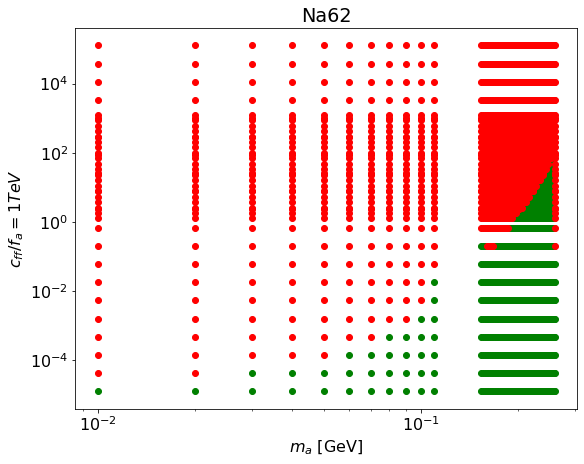

In [173]:
plt.figure(figsize=(9, 7))


plotAllAllowedConverted("output/m-tau-c-BRKtoPia-cff_combined.dat",0,2)
#plotWhiteRegions(10**(3))

plt.title('Na62')
plt.xlabel('$m_a$ [GeV]')
#plt.xlim(0.2,0.2)
plt.ylabel('$c_{ff}/f_a=1 TeV$')
plt.xscale("log")
plt.yscale("log")

# plt.xlim(9*10**-3, 4)
#plt.ylim(3*10**-4, 4*10**4)

plt.savefig('plots/Na62_cff_bound_oldAlps.png', dpi=300, bbox_inches='tight')

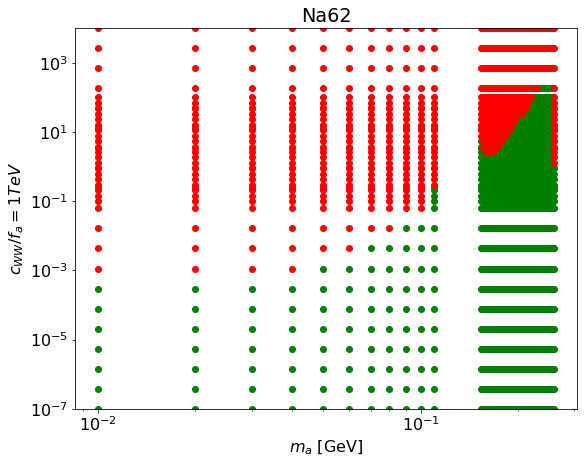

In [174]:
plt.figure(figsize=(9, 7))


plotAllAllowed("output/m-tau-c-BRKtoPia-cWW_combined.dat",0,2)
#plotWhiteRegions(10**(3))

plt.title('Na62')
plt.xlabel('$m_a$ [GeV]')
#plt.xlim(0.2,0.2)
plt.ylabel('$c_{WW}/f_a=1 TeV$')

# plt.xlim(9*10**-3, 4)
plt.ylim(10**-7, 10**4)

plt.xscale("log")
plt.yscale("log")

plt.savefig('plots/Na62_cWW_bound_oldAlps.png', dpi=300, bbox_inches='tight')

# Combined plots

In [51]:
# readArrayVisibleBoundBelleIIcffEqcWWEqcBB = np.load('output/visibleBoundBelleIIcffEqcWWEqcBB.npy')
readArrayVisibleBoundBelleIIcff = np.load('output/visibleBoundBelleIIcff.npy')
readArrayVisibleBoundBelleIIcWW = np.load('output/visibleBoundBelleIIcWW.npy')

In [52]:
BaBarBounds=genfromtxt('../ruth/BaBarBounds_readable.txt', delimiter='\t')
BaBarBoundsOld=genfromtxt('../ruth/BaBarBounds_readable_old.txt', delimiter='\t')

In [53]:
BellIIInvBounds05ab=genfromtxt('../ruth/BelleIIInvBounds_readable_0.5ab.txt', delimiter='\t')
BellIIInvBounds50ab=genfromtxt('../ruth/BelleIIInvBounds_readable_50ab.txt', delimiter='\t')

In [54]:
LHCbBoundscff=genfromtxt('output/LHCb_cff.dat', delimiter='\t')
LHCbBoundscWW=genfromtxt('output/LHCb_cWW.dat', delimiter='\t')

In [45]:
# function that plots cut-out regions from 1612.07818

def whiteregions(m):
    return np.heaviside(m - 0.25,0)*np.heaviside(-m + 0.4,0) + np.heaviside(m - 0.5,0)*np.heaviside(-m + 2.9,0)\
    + np.heaviside(m - 3.2,0)*np.heaviside(-m + 3.6,0) + np.heaviside(m - 3.9,0)*np.heaviside(-m + 4.7,0)
#     return np.heaviside(m - 3.9,0)*np.heaviside(-m + 4.7,0)

def plotWhiteRegions(yupper):
    m=np.linspace(0.2,5,num=10000);
    plt.fill_between(m,(1-whiteregions(m))*yupper,0,color="white",zorder=2)

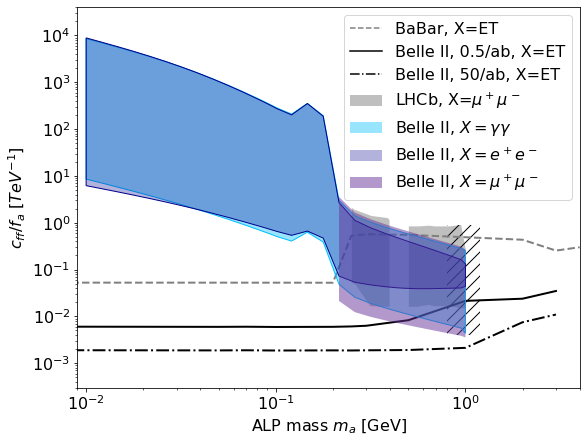

In [49]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(BaBarBounds[:,0],BaBarBounds[:,1],c="grey", ls='--',lw=2)
ax.plot(BellIIInvBounds05ab[:,0],BellIIInvBounds05ab[:,1],c="black", ls='-',lw=2)
ax.plot(BellIIInvBounds50ab[:,0],BellIIInvBounds50ab[:,1],c="black", ls='-.',lw=2)

plotGen(fromLambdatof(LHCbBoundscff),"oppacpolygon","grey",0,0.5, label='LHCb, X=$\mu^+ \mu^-$')
# plotGen(LHCbBounds,"nonfilledpolygon","grey",1)
plotWhiteRegions(10**(2))

plotGen(stackBounds(masslist,readArrayVisibleBoundBelleIIcff[:,5,0]*(4*np.pi),\
                    readArrayVisibleBoundBelleIIcff[:,5,1]*(4*np.pi)),"oppacpolygon","deepskyblue",0,0.4,\
                    label='Belle II, $X=\gamma \gamma $',zorder=3)
plotGen(stackBounds(masslist,readArrayVisibleBoundBelleIIcff[:,5,0]*(4*np.pi),\
                    readArrayVisibleBoundBelleIIcff[:,5,1]*(4*np.pi)),"nonfilledpolygon","deepskyblue",1,zorder=3)

plotGen(stackBounds(masslist,readArrayVisibleBoundBelleIIcff[:,0,0]*(4*np.pi),\
                    readArrayVisibleBoundBelleIIcff[:,0,1]*(4*np.pi)),"oppacpolygon","darkblue",0,0.3,\
                    label='Belle II, $X=e^+ e^-$',zorder=3)
plotGen(stackBounds(masslist,readArrayVisibleBoundBelleIIcff[:,0,0]*(4*np.pi),\
                    readArrayVisibleBoundBelleIIcff[:,0,1]*(4*np.pi)),"nonfilledpolygon","darkblue",1,zorder=3)

plotGen(stackBounds(masslist,readArrayVisibleBoundBelleIIcff[:,1,0]*(4*np.pi),\
                    readArrayVisibleBoundBelleIIcff[:,1,1]*(4*np.pi)),"oppacpolygon","rebeccapurple",0,0.5,\
                    label='Belle II, $X=\mu^+ \mu^-$',zorder=3)
# plotGen(stackBounds(masslist,readArrayVisibleBoundBelleIIcff[:,1,0],\
#                     readArrayVisibleBoundBelleIIcff[:,1,1]),"nonfilledpolygon","rebeccapurple",1)

p = mpatches.Rectangle((0.8,4*10**-3), 0.4, 0.9, linewidth=0, fill=None, hatch='//')
ax.add_patch(p)


# ax.set_title('Projected bounds on $BR( B^+ \\rightarrow K^+ + X )$')

ax.set_xlabel('ALP mass $m_a$ [GeV]')
ax.set_ylabel('$c_{ff}/f_a\ [TeV^{-1}]$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(9*10**-3, 4)
ax.set_ylim(3*10**-4, 4*10**4)

handles, labels = ax.get_legend_handles_labels()
babar= mlines.Line2D([], [], color='grey', linestyle='--',
                          markersize=15, label='BaBar, X='+"ET")
belleIIInv= mlines.Line2D([], [], color='black', linestyle='-',
                          markersize=15, label='Belle II, 0.5/ab, X='+"ET")
belleIIInv50= mlines.Line2D([], [], color='black', linestyle='-.',
                          markersize=15, label='Belle II, 50/ab, X='+"ET")
handles.insert(0, belleIIInv50)
handles.insert(0, belleIIInv) 
handles.insert(0, babar) 

ax.legend(handles=handles, loc='upper right')



#plt.savefig('plots/Bounds-projections-cff-50ab.png', dpi=300, bbox_inches='tight')

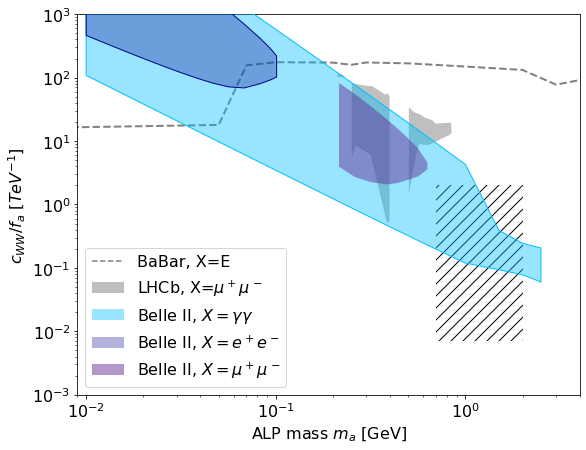

In [55]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(BaBarBounds[:,0],BaBarBounds[:,2],c="grey", ls='--',lw=2)

plotGen(fromLambdatof(LHCbBoundscWW),"oppacpolygon","grey",0,0.5, label='LHCb, X=$\mu^+ \mu^-$')
# plotGen(LHCbBounds,"nonfilledpolygon","grey",1)
plotWhiteRegions(10**(2))

plotGen(stackBounds(masslist,readArrayVisibleBoundBelleIIcWW[:,5,0]*(4*np.pi),\
                    readArrayVisibleBoundBelleIIcWW[:,5,1]*(4*np.pi)),"oppacpolygon","deepskyblue",0,0.4,\
                    label='Belle II, $X=\gamma \gamma $',zorder=3)
plotGen(stackBounds(masslist,readArrayVisibleBoundBelleIIcWW[:,5,0]*(4*np.pi),\
                    readArrayVisibleBoundBelleIIcWW[:,5,1]*(4*np.pi)),"nonfilledpolygon","deepskyblue",1,zorder=3)

plotGen(stackBounds(masslist,readArrayVisibleBoundBelleIIcWW[:,0,0]*(4*np.pi),\
                    readArrayVisibleBoundBelleIIcWW[:,0,1]*(4*np.pi)),"oppacpolygon","darkblue",0,0.3,\
                    label='Belle II, $X=e^+ e^-$',zorder=3)
plotGen(stackBounds(masslist,readArrayVisibleBoundBelleIIcWW[:,0,0]*(4*np.pi),\
                    readArrayVisibleBoundBelleIIcWW[:,0,1]*(4*np.pi)),"nonfilledpolygon","darkblue",1,zorder=3)

plotGen(stackBounds(masslist,readArrayVisibleBoundBelleIIcWW[:,1,0]*(4*np.pi),\
                    readArrayVisibleBoundBelleIIcWW[:,1,1]*(4*np.pi)),"oppacpolygon","rebeccapurple",0,0.5,\
                    label='Belle II, $X=\mu^+ \mu^-$',zorder=3)
# plotGen(stackBounds(masslist,readArrayVisibleBoundBelleIIcff[:,1,0],\
#                     readArrayVisibleBoundBelleIIcff[:,1,1]),"nonfilledpolygon","rebeccapurple",1)

p = mpatches.Rectangle((0.7,7*10**-3), 1.3, 2, linewidth=0, fill=None, hatch='//')
ax.add_patch(p)


# ax.set_title('Projected bounds on $BR( B^+ \\rightarrow K^+ + X )$')

ax.set_xlabel('ALP mass $m_a$ [GeV]')
ax.set_ylabel('$c_{WW}/f_a\ [TeV^{-1}]$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(9*10**-3, 4)
ax.set_ylim(10**-3, 10**3)

handles, labels = ax.get_legend_handles_labels()
babar= mlines.Line2D([], [], color='grey', linestyle='--',
                          markersize=15, label='BaBar, X='+"E")
handles.insert(0, babar) 

ax.legend(handles=handles)



#plt.savefig('plots/BoundBelleII-cWW-projections.png', dpi=300, bbox_inches='tight')